In [11]:
# -*- coding: utf-8 -*-
"""
Created on Sat november 05 13:18:15 2016
@author: Sidon
"""
%matplotlib inline
import pandas as pd
import numpy as np
from collections import OrderedDict
from tabulate import tabulate, tabulate_formats
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics
from sklearn.linear_model import LassoLarsCV
import warnings

warnings.filterwarnings('ignore')

# bug fix for display formats to avoid run time errors
pd.set_option('display.float_format', lambda x:'%f'%x)

usecols = ['country','incomeperperson','alcconsumption','armedforcesrate','breastcancerper100th','co2emissions',
           'femaleemployrate','internetuserate','lifeexpectancy','polityscore', 'relectricperperson',
           'suicideper100th', 'employrate', 'urbanrate']


# Load from CSV
data0 = pd.read_csv('~/dev/coursera/gapminder.csv', skip_blank_lines=True,
                     usecols=usecols)


In [12]:
def to_num(list, data):
    for dt in list :
        data[dt] = pd.to_numeric(data[dt], 'errors=coerce')
    return data    
        

In [13]:
columns = ['country','income','alcohol','army','bcancer','co2','female-employ','net-rate','life', 'polity',
           'relectricperperson', 'suicideper100th', 'employ','urban']

features = columns.copy()
for remove in ['country', 'life']:
    features.remove(remove)
    
features = ['income','alcohol','army', 'net-rate']    

In [14]:
# Rename columns for clarity                                    
data0.columns = columns

# converting to numeric values and parsing (numeric invalids=NaN)
data0 = to_num( features+['life'], data0 )

# Remove rows with nan values
data0 = data0.dropna(axis=0, how='any')

# Copy dataframe for preserve original
data1 = data0.copy()

In [15]:
# Convert Alcohol in a categorical var
meaa = data1.alcohol.mean()
mina = data1.alcohol.min() 
maxa = data1.alcohol.max()

# Categoriacal explanatory variable (Two levels based on mean) 
data1['alcohol'] = pd.cut(data0.alcohol,[np.floor(mina),meaa,np.ceil(maxa)], 
                          labels=[0,1])

cat1 = pd.qcut(data0.alcohol,5).cat.categories
data1["alcohol"] = pd.qcut(data0.alcohol,5,labels=['0','1','2','3','4'])
data1["alcohol"] = data1["alcohol"].astype('category')

In [16]:
# Convert Income in a categorical var
meai = data1.income.mean()
mini = data1.income.min() 
maxi = data1.income.max()

# Categoriacal explanatory variable (Two levels based on mean) 
data1['income'] = pd.cut(data0.income,[np.floor(mini),meai,np.ceil(maxi)], 
                          labels=[0,1])
data1["income"] = data1["income"].astype('category') 

In [17]:
data1 = to_num( ('alcohol', 'income'), data1 )

In [18]:
#select predictor variables and target variable as separate data sets  
pred_cols = features
predvar = data1[pred_cols]

# standardize predictors to have mean=0 and sd=1
predictors=predvar.copy()
predictors = to_num(pred_cols, predictors)

target = data1.life

from sklearn import preprocessing

for p in [pred_cols]:
    predictors[p]=preprocessing.scale(predictors[p].astype('float64'))

# split data into train and test sets
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target, 
                                                              test_size=.3, random_state=123)

# specify the lasso regression model
model=LassoLarsCV(cv=10, precompute=False).fit(pred_train,tar_train)

# print variable names and regression coefficients
coefs = dict(zip(predictors.columns, model.coef_))

print(tabulate(pd.DataFrame(list(coefs.items())), tablefmt="pipe", headers=['Variable', 'Coef']))

|    | Variable   |      Coef |
|---:|:-----------|----------:|
|  0 | alcohol    | -0.964523 |
|  1 | income     | -1.27532  |
|  2 | net-rate   |  8.39474  |
|  3 | army       |  1.2868   |


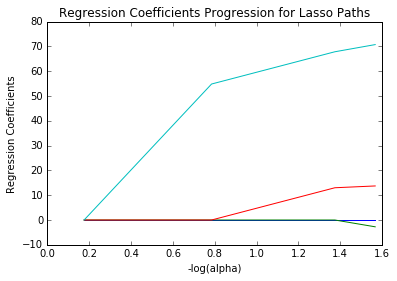

In [19]:
# plot coefficient progression
m_log_alphas = -np.log10(model.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, model.coef_path_.T)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')


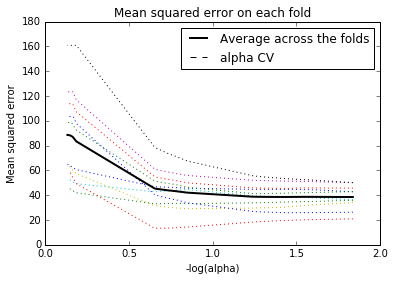

In [20]:
# plot mean square error for each fold
m_log_alphascv = -np.log10(model.cv_alphas_)
plt.figure()
plt.plot(m_log_alphascv, model.cv_mse_path_, ':')
plt.plot(m_log_alphascv, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')
         